In [148]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import(
    KFold,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
    GridSearchCV
)


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import(
    train_test_split,
    cross_val_score,
)

from sklearn.linear_model import(
    LassoCV,
    ElasticNetCV,
    LinearRegression
)

from sklearn.feature_selection import(
    VarianceThreshold,
    chi2,
    SelectKBest,
)

from sklearn.ensemble import(
    RandomForestRegressor,
    GradientBoostingRegressor,
    BaggingRegressor
)

from sklearn.metrics import(
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    explained_variance_score
)

from scipy.stats import skew

import pickle
import xgboost
from sklearn.externals import joblib

In [131]:
# Basic dummy variable dataframe

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
def transform_df(train): # train is only a placeholder name
    if "SalePrice" in train.columns:
        train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
    train['GarageYrBlt'].fillna(train['YearBuilt'], inplace=True)
    train["PoolQC"].fillna("None", inplace=True)
    train["MiscFeature"].fillna("None", inplace=True)
    train["Alley"].fillna("None", inplace=True)
    train["MasVnrArea"].fillna(0, inplace=True)
    train["Fence"].fillna("None", inplace=True)
    train["FireplaceQu"].fillna("None", inplace=True)
    # train["TotalSF"] = train["TotalBsmtSF"] + train["1stFlrSF"] + train["2ndFlrSF"]
    # train.drop(["TotalBsmtSF","1stFlrSF","2ndFlrSF"], axis=1, inplace=True)
    train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])
    train['KitchenQual'] = train['KitchenQual'].fillna(train['KitchenQual'].mode()[0])
    train['Exterior1st'] = train['Exterior1st'].fillna(train['Exterior1st'].mode()[0])
    train['Exterior2nd'] = train['Exterior2nd'].fillna(train['Exterior2nd'].mode()[0])
    train['SaleType'] = train['SaleType'].fillna(train['SaleType'].mode()[0])

    train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(
        lambda x: x.fillna(x.median()))
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
        train[col] = train[col].fillna('None') 
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        train[col] = train[col].fillna(0)
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        train[col] = train[col].fillna('None')
    train["Functional"] = train["Functional"].fillna("Typ")
    train.drop(['Utilities'], axis=1, inplace=True)
    return train

def categorize(df):
    df['MSSubClass'] = df['MSSubClass'].astype("str")
    df['OverallCond'] = df['OverallCond'].astype("str")
    df['YrSold'] = df['YrSold'].astype("str")
    df['MoSold'] = df['MoSold'].astype("str")
    df["OverallQual"] = df['OverallQual'].astype("str")

    return df

train = categorize(train)
def unskew(train):
    numeric_feats = train.dtypes[train.dtypes != "object"].index

    # Applying logarithmic transform to skewed features
    # This code was pulled from Alexandru Papiu:
    # https://www.kaggle.com/apapiu/regularized-linear-models

    skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > 0.75]
    skewed_feats = skewed_feats.index
    train[skewed_feats] = np.log1p(train[skewed_feats])
    return train


train = transform_df(train)
train = categorize(train)
train = unskew(train)
train_dummies = pd.get_dummies(train)


test = transform_df(test)
test = categorize(test)
test = unskew(test)
test_dummies = pd.get_dummies(test)


In [132]:
# msno.bar(train_dummies)
len(test_dummies.columns)

331

In [133]:
# set(train_dummies.columns) - set(test_dummies.columns)
import copy
train_objs_num = len(train_dummies)
dataset = pd.concat(objs=[train_dummies, test_dummies], axis=0)
dataset = pd.get_dummies(dataset)
train_dummies = copy.copy(dataset[:train_objs_num])
test_dummies = copy.copy(dataset[train_objs_num:])

In [134]:
test_dummies = test_dummies.fillna(0)
train_dummies = train_dummies.fillna(0)

In [136]:
# df = df.drop()
# train_dummies.columns.str.contains('None')
def drop_certain(df): # Train_dummies is just a placeholder
    df = df[df.columns[~df.columns.str.contains('_None')]]
    df = df[df.columns[~df.columns.str.contains('Exterior2nd')]]
    df = df.drop('MSZoning_RL', axis=1)
    df = df.drop('PavedDrive_N', axis=1)
    df = df.drop('MSZoning_RM', axis=1)
    df = df.drop('SaleCondition_Partial', axis=1)
    df = df.drop('MiscFeature_Shed', axis=1)
    # df = df.drop('Exterior2nd_VinylSd', axis=1, inplace=True)
    # df = df.drop('Exterior2nd_CmentBd', axis=1, inplace=True)
    # df = df.drop('Exterior2nd_MetalSd', axis=1, inplace=True)
    df = df.drop('MSSubClass_190', axis=1)
    df = df.drop('MSSubClass_80', axis=1)
    df = df.drop('MSSubClass_50', axis=1)
    df = df.drop('MSSubClass_40', axis=1)
    df = df.drop('MSSubClass_45', axis=1)
    df = df.drop("Street_Grvl", axis=1)
    df = df.drop("LotShape_Reg", axis=1)
    df = df.drop("CentralAir_N", axis=1)
    df = df.drop("LandSlope_Gtl", axis=1)
    return df
train_dummies = drop_certain(train_dummies)
test_dummies = drop_certain(test_dummies)

In [137]:
### Correlation Plots

def corrgraphs(df):
    neg = df.corr()[df.corr() < -0.75]
    neg = neg.dropna(how="all", axis=1)
    neg = neg.dropna(how="all", axis=0)
    pos = df.corr()[df.corr() > 0.75]
    pos = pos[pos < 1.0]
    pos = pos.dropna(how="all", axis=1)
    pos = pos.dropna(how="all", axis=0)
    return (neg, pos)
neg, pos = corrgraphs(test_dummies)

/Users/deangoldman/Library/Python/3.6/lib/python/site-packages/matplotlib/artist.py:879: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


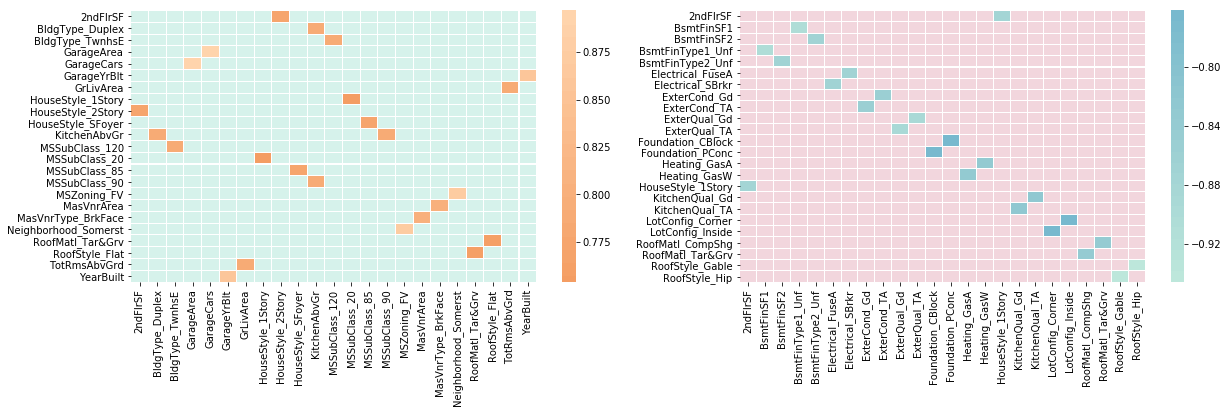

In [138]:
def plot_corrgraphs(neg, pos):
    fig, axs = plt.subplots(ncols=2, figsize=(20,5))
    pos_heatmap = sns.heatmap(pos, center=0, linewidths=0.01, ax=axs[0])
    pos_heatmap.set(axis_bgcolor="#D6F2EB")
    neg_heatmap = sns.heatmap(neg, center=0, linewidths=0.01, ax=axs[1])
    neg_heatmap.set(axis_bgcolor="#F2D6DD")
    return
plot_corrgraphs(neg, pos)

In [104]:
# # Example plot
# regplot = sns.regplot(x = 'KitchenQual', y = 'SalePrice', data = df, color = '#FFB733')
# regplot.set(axis_bgcolor="#A2BFF4")

In [74]:
# plt.scatter(train_dummies["GrLivArea"], train_dummies["SalePrice"])

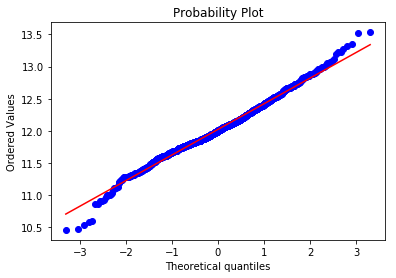

In [60]:
fig = plt.figure()
res = stats.probplot(train_dummies['SalePrice'], plot=plt)
plt.show()

In [919]:
# Full dataframe into Train-test Split
def full_set_split(df):
    X = df.drop(["SalePrice","Id"], axis=1)
#     X = vif_filter(X, thresh=5)
    y = df["SalePrice"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    return (X_train, X_test, y_train, y_test)

In [139]:
# Full dataframe into Train-test Split
def X_y_split(df):
    X = df.drop(["SalePrice","Id"], axis=1)
#     X = vif_filter(X, thresh=5)
    y = df["SalePrice"]
    return (X, y)

In [140]:
# df = unskew(train_dummies)
# X_train, X_test, y_train, y_test = full_set_split(train_dummies)
X, y = X_y_split(train_dummies)
# test = pd.read_csv("test.csv")
test = test_dummies
test_id = test["Id"]
test.drop(["SalePrice", "Id"], axis=1, inplace=True)

# Modeling

In [924]:
# Calculate RMSE
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [142]:
lm = LinearRegression().fit(X, y)

In [143]:
model_lasso = LassoCV(normalize=True, cv=6).fit(X, y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [144]:
elastic_net = ElasticNetCV(alphas=[.001], max_iter=5000).fit(X, y)

In [145]:
gboost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.085,
                                   max_depth=2, max_features=10,loss="huber").fit(X, y)

In [146]:
model_xgb = xgboost.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1).fit(X, y)

In [149]:
bag = BaggingRegressor(base_estimator=elastic_net, n_estimators=10).fit(X, y)

In [150]:
combined_pred = (
    lm.predict(test) +
    model_xgb.predict(test) +
    bag.predict(test) +
    model_lasso.predict(test) +
    elastic_net.predict(test) +
    gboost.predict(test)) / 6
# print('R2: {}'.format(r2_score(combined_pred, y_test)))

In [155]:
np.exp(combined_pred)

array([164451.9871056 , 197194.39508097, 247327.98212251, ...,
       317892.1752919 , 146991.70331313, 271193.81595219])

In [160]:
submission = pd.DataFrame({'Id': test_id, 'SalePrice': np.exp(elastic_net.predict(test))})

In [161]:
len(submission)

1459

In [162]:
submission.to_csv('submission.csv', index=False)

In [939]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
print(rmse(combined_pred, y_test))

0.11527464447642781


In [824]:
all_preds = pd.DataFrame({"preds": combined_pred,
                          "lm": lm.predict(X_test),
                          "model_lasso": model_lasso.predict(X_test),
                          "model_xgb": model_xgb.predict(X_test),
                          "elastic_net": elastic_net.predict(X_test),
                          "bag_regressor": bag.predict(X_test),
                          "true":y_test
                         })
fig, ax = plt.subplots(figsize=(5,5))
ax.set_axis_bgcolor("#eefeee")
sns.regplot(x='true', y='preds', data=all_preds, ax=ax, color="#95a5a6", scatter_kws={'alpha':.3})
# ax2 = ax.twinx()
# sns.regplot(x='true', y='lm', data=all_preds, ax=ax2, color="r", scatter_kws={'alpha':0})
# ax3 = ax.twinx()
# sns.regplot(x='true', y='model_lasso', data=all_preds, ax=ax3, color="#2ecc71", scatter_kws={'alpha':0})
# ax3 = ax.twinx()
# sns.regplot(x='true', y='bag_regressor', data=all_preds, ax=ax3, color="#2ecc71", scatter_kws={'alpha':0})

# ax4 = ax.twinx()
# sns.regplot(x='true', y='elastic_net', data=all_preds, ax=ax4, color="#3498db", scatter_kws={'alpha':0})

# ax5 = ax.twinx()
# sns.regplot(x='true', y='model_xgb', data=all_preds, ax=ax5, color="#FF69B4", scatter_kws={'alpha':.4})
ax6 = ax.twinx()
sns.regplot(x='true', y='true', data=all_preds, ax=ax6, color="#34495e", scatter_kws={'alpha': 0.1})

ValueError: feature_names mismatch: ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MSSubClass_120', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_85', 'MSSubClass_90', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'Street_Pave', 'Alley_Grvl', 'Alley_Pave', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Fin', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'OverallQual_1', 'OverallQual_10', 'OverallQual_2', 'OverallQual_3', 'OverallQual_4', 'OverallQual_5', 'OverallQual_6', 'OverallQual_7', 'OverallQual_8', 'OverallQual_9', 'OverallCond_1', 'OverallCond_2', 'OverallCond_3', 'OverallCond_4', 'OverallCond_5', 'OverallCond_6', 'OverallCond_7', 'OverallCond_8', 'OverallCond_9', 'RoofStyle_Flat', 'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing', 'MasVnrType_BrkCmn', 'MasVnrType_Stone', 'ExterQual_Ex', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'ExterCond_Ex', 'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_Po', 'ExterCond_TA', 'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtCond_Fa', 'BsmtCond_Gd', 'BsmtCond_Po', 'BsmtCond_TA', 'BsmtExposure_Av', 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'BsmtFinType2_ALQ', 'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_LwQ', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf', 'Heating_Floor', 'Heating_GasA', 'Heating_GasW', 'Heating_Grav', 'Heating_OthW', 'Heating_Wall', 'HeatingQC_Ex', 'HeatingQC_Fa', 'HeatingQC_Gd', 'HeatingQC_Po', 'HeatingQC_TA', 'CentralAir_Y', 'Electrical_FuseF', 'Electrical_FuseP', 'Electrical_Mix', 'Electrical_SBrkr', 'KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA', 'Functional_Maj1', 'Functional_Maj2', 'Functional_Min1', 'Functional_Min2', 'Functional_Mod', 'Functional_Sev', 'Functional_Typ', 'FireplaceQu_Ex', 'FireplaceQu_Fa', 'FireplaceQu_Gd', 'FireplaceQu_Po', 'FireplaceQu_TA', 'GarageType_2Types', 'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd', 'GarageFinish_Fin', 'GarageFinish_RFn', 'GarageFinish_Unf', 'GarageQual_Ex', 'GarageQual_Fa', 'GarageQual_Gd', 'GarageQual_Po', 'GarageQual_TA', 'GarageCond_Ex', 'GarageCond_Fa', 'GarageCond_Gd', 'GarageCond_Po', 'GarageCond_TA', 'PavedDrive_P', 'PavedDrive_Y', 'PoolQC_Ex', 'PoolQC_Fa', 'PoolQC_Gd', 'Fence_GdPrv', 'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw', 'MiscFeature_Gar2', 'MiscFeature_Othr', 'MiscFeature_TenC', 'MoSold_1', 'MoSold_10', 'MoSold_11', 'MoSold_12', 'MoSold_2', 'MoSold_3', 'MoSold_4', 'MoSold_5', 'MoSold_6', 'MoSold_7', 'MoSold_8', 'MoSold_9', 'YrSold_2006', 'YrSold_2007', 'YrSold_2008', 'YrSold_2009', 'YrSold_2010', 'SaleType_COD', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD', 'SaleCondition_Abnorml', 'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal'] ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MSSubClass_120', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_85', 'MSSubClass_90', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'Street_Pave', 'Alley_Grvl', 'Alley_Pave', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Fin', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'OverallQual_1', 'OverallQual_10', 'OverallQual_2', 'OverallQual_3', 'OverallQual_4', 'OverallQual_5', 'OverallQual_6', 'OverallQual_7', 'OverallQual_8', 'OverallQual_9', 'OverallCond_1', 'OverallCond_2', 'OverallCond_3', 'OverallCond_4', 'OverallCond_5', 'OverallCond_6', 'OverallCond_7', 'OverallCond_8', 'OverallCond_9', 'RoofStyle_Flat', 'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing', 'MasVnrType_BrkCmn', 'MasVnrType_BrkFace', 'MasVnrType_Stone', 'ExterQual_Ex', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'ExterCond_Ex', 'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_Po', 'ExterCond_TA', 'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtCond_Fa', 'BsmtCond_Gd', 'BsmtCond_Po', 'BsmtCond_TA', 'BsmtExposure_Av', 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'BsmtFinType2_ALQ', 'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_LwQ', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf', 'Heating_Floor', 'Heating_GasA', 'Heating_GasW', 'Heating_Grav', 'Heating_OthW', 'Heating_Wall', 'HeatingQC_Ex', 'HeatingQC_Fa', 'HeatingQC_Gd', 'HeatingQC_Po', 'HeatingQC_TA', 'CentralAir_Y', 'Electrical_FuseF', 'Electrical_FuseP', 'Electrical_Mix', 'Electrical_SBrkr', 'KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA', 'Functional_Maj1', 'Functional_Maj2', 'Functional_Min1', 'Functional_Min2', 'Functional_Mod', 'Functional_Sev', 'Functional_Typ', 'FireplaceQu_Ex', 'FireplaceQu_Fa', 'FireplaceQu_Gd', 'FireplaceQu_Po', 'FireplaceQu_TA', 'GarageType_2Types', 'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd', 'GarageFinish_Fin', 'GarageFinish_RFn', 'GarageFinish_Unf', 'GarageQual_Ex', 'GarageQual_Fa', 'GarageQual_Gd', 'GarageQual_Po', 'GarageQual_TA', 'GarageCond_Ex', 'GarageCond_Fa', 'GarageCond_Gd', 'GarageCond_Po', 'GarageCond_TA', 'PavedDrive_P', 'PavedDrive_Y', 'PoolQC_Ex', 'PoolQC_Fa', 'PoolQC_Gd', 'Fence_GdPrv', 'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw', 'MiscFeature_Gar2', 'MiscFeature_Othr', 'MiscFeature_TenC', 'MoSold_1', 'MoSold_10', 'MoSold_11', 'MoSold_12', 'MoSold_2', 'MoSold_3', 'MoSold_4', 'MoSold_5', 'MoSold_6', 'MoSold_7', 'MoSold_8', 'MoSold_9', 'YrSold_2006', 'YrSold_2007', 'YrSold_2008', 'YrSold_2009', 'YrSold_2010', 'SaleType_COD', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD', 'SaleCondition_Abnorml', 'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal']
training data did not have the following fields: MasVnrType_BrkFace

In [73]:
print(mean_absolute_error(y_test, combined_pred))
print(mean_absolute_error(y_test, elastic_net.predict(X_test)))
print(mean_absolute_error(y_test, model_lasso.predict(X_test)))
print(mean_absolute_error(y_test, model_xgb.predict(X_test)))
print(mean_absolute_error(y_test, lm.predict(X_test)))

0.07530413366151853
0.07828444201268202
0.07921988167186991
0.0854422582531566
0.08495947051515414


In [62]:
print(explained_variance_score(y_test, combined_pred))
print(explained_variance_score(y_test, elastic_net.predict(X_test)))
print(explained_variance_score(y_test, model_lasso.predict(X_test)))
print(explained_variance_score(y_test, model_xgb.predict(X_test)))

0.9283142307085968
0.9248232057787331
0.9221032348473697
0.9069201957865901


In [63]:
print(mean_squared_error(y_test, combined_pred))
print(mean_squared_error(y_test, elastic_net.predict(X_test)))
print(mean_squared_error(y_test, model_lasso.predict(X_test)))
print(mean_squared_error(y_test, model_xgb.predict(X_test)))

0.010853276675726952
0.011390469662362054
0.011788577840345375
0.014120293219261967


In [244]:
predictions_df = pd.DataFrame([model_lasso_predict, elastic_net_predict,
                               gboost_predict, model_xgb_predict,
                               lm_predict])
predictions_df = predictions_df.T.rename(index=str, columns = {0:"Lasso",
                                                               1:"ElasticNet",
                                                               2:"GradientBoost",
                                                               3:"XGB", 4:"LM" })
len(predictions_df)
predictions_df_stack = pd.DataFrame([model_lasso_predict_stack, elastic_net_predict_stack,
                                     gboost_predict_stack, model_xgb_predict_stack,
                                     lm_predict_stack])
predictions_df_stack = predictions_df_stack.T.rename(index=str, columns = {0:"Lasso",
                                                                           1:"ElasticNet",
                                                                           2:"GradientBoost",
                                                                           3:"XGB", 4:"LM" })
y_test1 = pd.DataFrame(y_test.reset_index()).drop("index", axis=1)["SalePrice"]
stack_gboost = GradientBoostingRegressor(n_estimators=2000)
stack_gboost.fit(predictions_df, y_test1)
# rf_stack = RandomForestRegressor(n_estimators=2000, max_depth=2).fit(predictions_df, y_test1)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [619]:
from sklearn.ensemble import BaggingRegressor

In [194]:
# lm = LinearRegression().fit(predictions_df, y_test1)


# print(lm.score(predictions_df_stack, y_test_stack))
# print(rmse_cv_stack(lm, predictions_df_stack, y_test_stack).mean())

0.8005037908630646
0.132631237420204


In [218]:
# Calculate RMSE
def rmse_cv_stack(model, X, y):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)
print(stack_gboost.score(predictions_df_stack, y_test_stack))
print(rmse_cv_stack(stack_gboost, predictions_df_stack, y_test_stack).mean())

0.8724407189572899
0.1369813452012161


In [401]:
# PCA workflow not being used atm.

# pca = PCA()
# # scaled_data = scale(X_train.T)
# # pca.fit(scaled_data)    

# pca.fit(scale(X_train))
# pca_data = pca.transform(scale(X_train))

# per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
# labels = ["PC" + str(x) for x in range(1, len(per_var) + 1)]
# plt.bar(left=range(1,6), height=per_var[:5], tick_label=labels[:5])
# plt.show()

# pca_df = pd.DataFrame(pca_data)
# plt.scatter(pca_df[0], pca_df[1], pca_df[3], c=["red","blue","green"])

In [34]:
# le = LabelEncoder()
# le.fit(train["KitchenQual"])
# list(le.classes_)
# tdf = pd.DataFrame([le.transform(train["KitchenQual"]),
#                    train["KitchenQual"],
#                    train["SalePrice"]]).T
# tdf.rename(columns={0:"Encoded", 1:"Original", 2:"SalePrice"}, inplace=True)

In [9]:
# def ordinal_to_numeric(df):
#     for i in range(len(df.columns)-1):
#         is_cat = df.iloc[:,i].values.any() in ("Gd","Ex","TA","Fa","Po")
#         if is_cat == True:
#             df[df.columns[i]] = df[df.columns[i]].map({"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1})
#     return df